In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import warnings

SEED = 31415926
random.seed(SEED)
np.random.seed(SEED)

# Filter out FutureWarning complaining about categorical type somewhere in pandas
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import matplotlib
matplotlib.__version__

'3.5.1'

In [3]:
sns.__version__

'0.12.2'

In [4]:
# Table also can be found here: https://docs.google.com/spreadsheets/d/1VOAnyBxzia71Gcv_MgTcDT4W06Wl2_4N/edit#gid=996240860
DATA_PATH = "data/2024_04_12_Single cell studies database.csv"
# DATA_PATH = "http://www.nxn.se/single-cell-studies/data.tsv"

In [5]:
df = pd.read_csv(DATA_PATH, index_col=0)
df

,DOI,Authors,Journal,Title,Date,bioRxiv DOI,Reported cells total,Organism,Tissue,Technique,...,Number of reported cell types or clusters,Cell clustering,Pseudotime,RNA Velocity,PCA,tSNE,H5AD location,Isolation,BC --> Cell ID _OR_ BC --> Cluster ID,Number individuals
Shorthand,,,,,,,,,,,,,,,,,,,,,
Cauli et al PNAS,10.1073/pnas.97.11.6144,"B. Cauli, J. T. Porter, K. Tsuzuki, B. Lambole...",Proceedings of the National Academy of Sciences,Classification of fusiform neocortical interne...,20020726,-,85,Rat,Brain,sc-RT-mPCR,...,3,Yes,No,No,Yes,No,NaN,Patch-clamp,NaN,NaN
Malnic et al Cell,10.1016/S0092-8674(00)80581-4,"Bettina Malnic, Junzo Hirono, Takaaki Sato, Li...",Cell,Combinatorial Receptor Codes for Odors,20040410,-,18,Mouse,Brain,PCR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tietjen et al Neuron,10.1016/S0896-6273(03)00229-0,"Ian Tietjen, Jason M. Rihel, Yanxiang Cao, Geo...",Neuron,Single-Cell Transcriptional Analysis of Neuron...,20040415,-,37,"Human, Mouse",Brain,PCR,...,6,NaN,NaN,NaN,NaN,NaN,NaN,"Manual, LCM",NaN,2.0
Gallopin et al CCortex,10.1093/cercor/bhj081,"Thierry Gallopin, Hélène Geoffroy, Jean Rossie...",Cerebral Cortex,"Cortical Sources of CRF, NKB, and CCK and Thei...",20051208,-,157,Rat,Brain,sc-RT-mPCR,...,4,Yes,No,No,Yes,No,NaN,Patch-clamp,NaN,NaN
Kurimoto et al NAR,10.1093/nar/gkl050,K. Kurimoto,Nucleic Acids Research,An improved single-cell cDNA amplification met...,20060330,-,20,Mouse,ICM,aRNA amplification,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Salcher et al Heliyon,10.1016/j.heliyon.2024.e28358,"Stefan Salcher, Isabel Heidegger, Gerold Unter...",Heliyon,Comparative analysis of 10X Chromium vs. BD Rh...,20240319,NaN,"47,844",Human,Prostate,BD Rhapsody & Chromium,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
Zhang et al NImmunology,10.1038/s41590-024-01782-4,"Xuan Zhang, Baobao Song, Maximillian J. Carlin...",Nat Immunol,An immunophenotype-coupled transcriptomic atla...,20240321,NaN,"315,000",Human,Bone marrow,CITE-seq,...,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
Peng et al bioRxiv,10.1101/2024.03.20.586024,"Yang Peng, Yilin Li, Jixing Ao, Jia Shen, Xian...",bioRxiv,Single-cell profiling reveals the intratumor h...,20240321,10.1101/2024.03.20.586024,"102,012",Human,"Cervix, Tumor",Chromium,...,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0


In [6]:
is_included = (df["Tissue"] != "Culture") & \
              (df["Tissue"] != "Cullture") & \
              (df["Tissue"] != "Organoid") & \
              (df["Tissue"] != "Xenodraft") & \
              (df["Organism"].str.contains("Human"))

print("Before exclusion:", df.shape)
df = df.loc[is_included, :]
print("After exclusion:", df.shape)

Before exclusion: (1958, 27)
After exclusion: (769, 27)


In [7]:
df["Number individuals"].notna().sum()

671

In [8]:
df["Organism"].value_counts()

Organism
Human                                                                        636
Human, Mouse                                                                 102
Mouse, Human                                                                   8
Human, Macaque                                                                 2
Cynomolgus macaque, Human, Mouse, Pig, Rhesus macaque                          2
Mouse, Human, Dog                                                              1
Human, Mouse, Rat                                                              1
Human, Marmoset, Mouse                                                         1
Human, Mouse, Macaque                                                          1
Human, Rabbit                                                                  1
Human, Macaque, Mouse                                                          1
Bonobo, Chimpanzee, Human, Macaque                                             1
Human, Rat         

In [9]:
def get_date(number):
    """Extract year, month and day from the date in form of integer number
    
    Examples
    --------
    >>> get_date(20020726)
    (2020, 26, 07)
    """

    if "/" in number:
        day, month, year = number.split("/")

    else:
        if len(str(number)) != 8:
            raise ValueError(f"{number} has incorrect format")

        number = str(number)
        year = number[:4]
        month = number[4:6]
        day = number[6:]

    return year, month, day


def remove_comma_from_number(s):
    if isinstance(s, str):
        return s.replace(",", "")
    
    return s

In [10]:
dates = df["Date"].astype(str).apply(get_date).values
df["date"] = [f"{year}-{month}-{day}" for year, month, day in dates]

df["year"] = [date[0] for date in dates]
df["month"] = [date[1] for date in dates]
df["day"] = [date[2] for date in dates]

df["date"] = pd.to_datetime(df["date"])

df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)
df["day"] = df["day"].astype(int)

df["Reported cells total"] = df["Reported cells total"].apply(remove_comma_from_number)
df["Reported cells total"] = df["Reported cells total"].astype(float)
df["cells_per_donor"] = df["Reported cells total"] / df["Number individuals"]

df = df.loc[df["year"] < 2024]  # The data for 2023 is not complete yet

/var/folders/p9/74j47tdn36n6s2vcv_5079q0s4wk4h/T/ipykernel_27458/1906640918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = [f"{year}-{month}-{day}" for year, month, day in dates]
/var/folders/p9/74j47tdn36n6s2vcv_5079q0s4wk4h/T/ipykernel_27458/1906640918.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = [date[0] for date in dates]
/var/folders/p9/74j47tdn36n6s2vcv_5079q0s4wk4h/T/ipykernel_27458/1906640918.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [11]:
df.columns

Index(['DOI', 'Authors', 'Journal', 'Title', 'Date', 'bioRxiv DOI',
       'Reported cells total', 'Organism', 'Tissue', 'Technique',
       'Data location', 'Panel size', 'Measurement', 'Cell source', 'Disease',
       'Contrasts', 'Developmental stage',
       'Number of reported cell types or clusters', 'Cell clustering',
       'Pseudotime', 'RNA Velocity', 'PCA', 'tSNE', 'H5AD location',
       'Isolation', 'BC --> Cell ID _OR_ BC --> Cluster ID',
       'Number individuals', 'date', 'year', 'month', 'day',
       'cells_per_donor'],
      dtype='object')

In [12]:
df[df["Number individuals"] > 400]

,DOI,Authors,Journal,Title,Date,bioRxiv DOI,Reported cells total,Organism,Tissue,Technique,...,tSNE,H5AD location,Isolation,BC --> Cell ID _OR_ BC --> Cluster ID,Number individuals,date,year,month,day,cells_per_donor
Shorthand,,,,,,,,,,,,,,,,,,,,,
Sun et al bioRxiv,10.1101/2022.02.09.479797,"Na Sun, Leyla Anne Akay, Mitchell H. Murdock, ...",bioRxiv,Single-cell multi-region dissection of brain v...,20220210,10.1101/2022.02.09.479797,22514.0,Human,Brain,Chromium,...,NaN,NaN,NaN,NaN,428.0,2022-02-10,2022,2,10,52.602804
Yazar et al Science,10.1126/science.abf3041,"Seyhan Yazar, Jose Alquicira-Hernandez, Kristo...",Science,Single-cell eQTL mapping identifies cell type–...,20220407,NaN,1267758.0,Human,Blood,Chromium,...,NaN,NaN,NaN,NaN,982.0,2022-04-07,2022,4,7,1290.995927
Sikkema et al NMedicine,10.1038/s41591-023-02327-2,"Lisa Sikkema, Ciro Ramírez-Suástegui, Daniel C...",Nat Med,An integrated cell atlas of the lung in health...,20230608,NaN,2400000.0,Human,Lung,Chromium,...,NaN,NaN,NaN,NaN,486.0,2023-06-08,2023,6,8,4938.271605
Mathys et al Cell,10.1016/j.cell.2023.08.039,"Hansruedi Mathys, Zhuyu Peng, Carles A. Boix, ...",Cell,Single-cell atlas reveals correlates of high c...,20230928,NaN,2300000.0,Human,Brain,Chromium,...,NaN,NaN,NaN,NaN,427.0,2023-09-28,2023,9,28,5386.416862


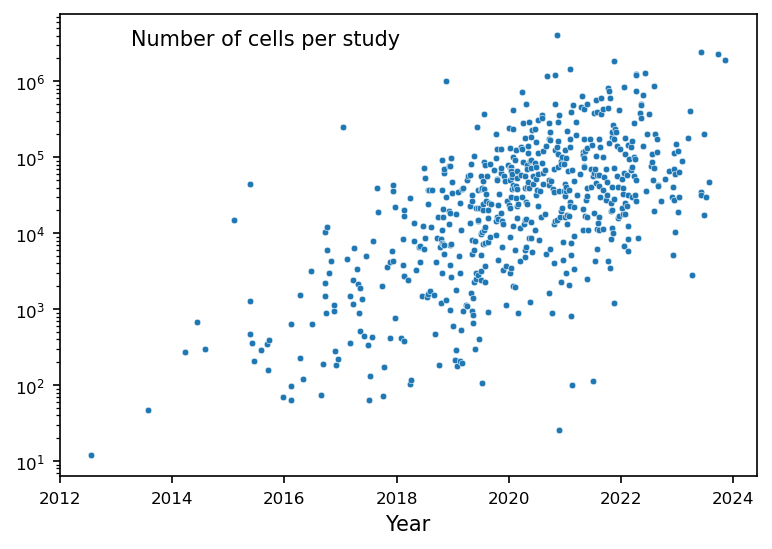

In [13]:
plt.figure(figsize=(6, 4), dpi=150)

sns.scatterplot(data=df.loc[df["year"] > 2005], x="date", y="Reported cells total", s=10)
plt.text(15800, 30e5, "Number of cells per study")

plt.yscale("log")
plt.ylabel("")
plt.xlabel("Year")

plt.yticks(size=8);
plt.xticks(size=8);

<AxesSubplot:xlabel='Number individuals', ylabel='Count'>

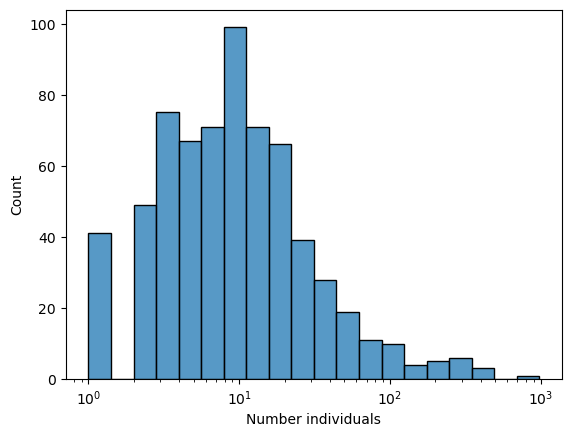

In [14]:
sns.histplot(df["Number individuals"], log_scale=True)
# plt.yscale("log")

In [15]:
df[["Number individuals"]].describe()

,Number individuals
count,665.000000
mean,22.010526
std,58.798678
min,1.000000
25%,4.000000
50%,8.000000
75%,18.000000
max,982.000000


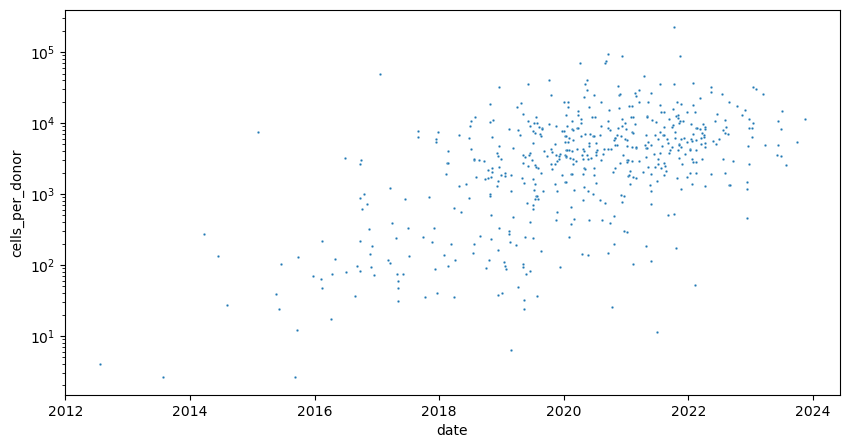

In [16]:
plt.figure(figsize=(10, 5), dpi=100)

sns.scatterplot(data=df.loc[df["year"] > 2005], x="date", y="cells_per_donor", s=3)

# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
plt.yscale("log")

/Users/vladimir.shitov/miniconda3/envs/2023_09_papers_mining/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 16.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/vladimir.shitov/miniconda3/envs/2023_09_papers_mining/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 27.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/vladimir.shitov/miniconda3/envs/2023_09_papers_mining/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 34.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/vladimir.shitov/miniconda3/envs/2023_09_papers_mining/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 25.7% of the points cannot be placed; you may want to decre

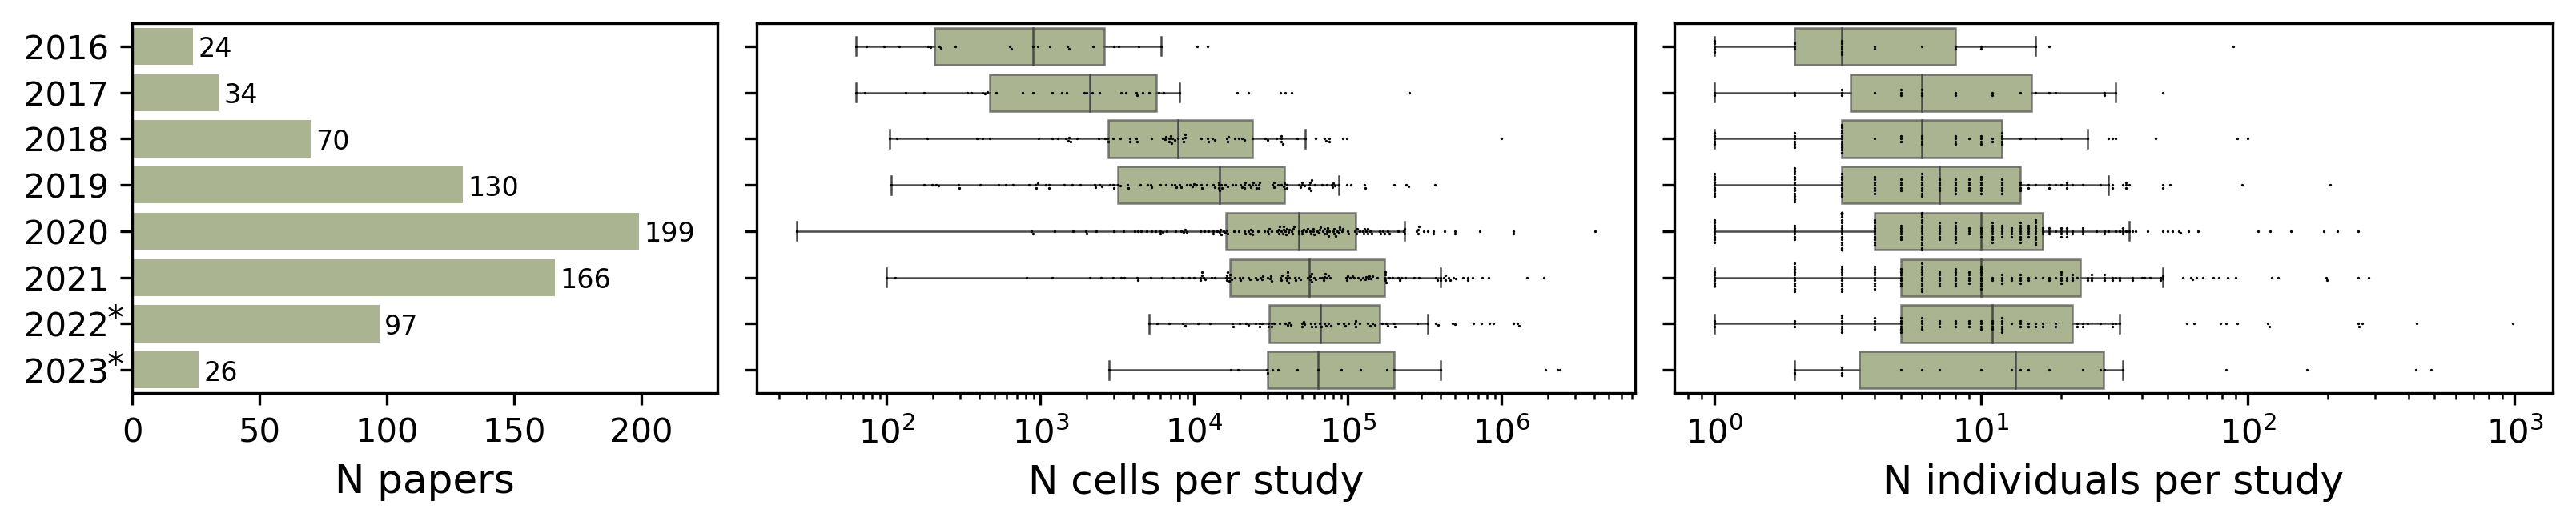

In [17]:
N_PAPERS_IDX = 0
N_INDS_IDX = 2
N_CELLS_IDX = 1
NO_BOXES_POINT_SIZE = 2
PLOT_COLOR = "#8A9E59"

boxplot_params = dict(
    orient="h",
    linewidth=0.6,
    fliersize=3, 
    flierprops={"marker": "x", "markeredgewidth": 1.5, "markeredgecolor": "#666666"},
    boxprops={"alpha": 0.7},
    color=PLOT_COLOR,
    showfliers=False
)

swarmplot_params = dict(
    orient="h",
    color="black",
    size=0.8,
    legend=None
)

tissues_df = df.copy().reset_index()
tissues_df = tissues_df.loc[tissues_df["year"] > 2015]

fig, axes = plt.subplots(figsize=(13, 2), dpi=300, ncols=3, sharey=True,
                         gridspec_kw={"width_ratios": [2, 3, 3], "wspace": 0.05})

# Plot distribution of number of individuals
sns.boxplot(
    data=tissues_df,
    y="year",
    x="Number individuals",
    ax=axes[N_INDS_IDX],
    **boxplot_params
)

# Plot points as circles over boxplots (where boxes are plotted)
sns.swarmplot(
    data=tissues_df,
    y="year",
    x="Number individuals",
    ax=axes[N_INDS_IDX],
    **swarmplot_params
)

# Plot number of papers per category

g = sns.countplot(
    data=tissues_df,
    y="year",
    orient="h",
    linewidth=0.3,
    ax=axes[N_PAPERS_IDX],
    alpha=0.7,
    color=PLOT_COLOR
)

# Put text above bars
for bar in g.patches:
    y = bar.get_y()
    length = bar.get_width()
    axes[N_PAPERS_IDX].text(y=y + 0.45, x=length+2, s=int(length), ha="left", va="center", size=8)

# Plot number of cells per paper
sns.boxplot(
    data=tissues_df,
    y="year",
    x="Reported cells total",
    ax=axes[N_CELLS_IDX],
    **boxplot_params
)

# Plot points as circles over boxplots (where boxes are plotted)
sns.swarmplot(
    data=tissues_df,
    y="year",
    x="Reported cells total",
    ax=axes[N_CELLS_IDX],
    **swarmplot_params
)

axes[N_PAPERS_IDX].set_xlabel("N papers", size=12)
axes[N_INDS_IDX].set_xlabel("N individuals per study", size=12)
axes[N_CELLS_IDX].set_xlabel("N cells per study", size=12)

# axes[N_PAPERS_IDX].set_xlabel("Year", size=20)
axes[N_CELLS_IDX].set_ylabel("")
axes[N_INDS_IDX].set_ylabel("")
axes[N_PAPERS_IDX].set_ylabel("")

# axes[N_INDS_IDX].set_xlim(0, n_inds_plot_lim)
axes[N_INDS_IDX].set_xscale("log")
axes[N_PAPERS_IDX].set_xlim(0, 230)
axes[N_PAPERS_IDX].set_ylabel("")
axes[N_CELLS_IDX].set_xscale("log")

axes[N_CELLS_IDX].tick_params(axis="both", which="major", labelsize=10)
axes[N_INDS_IDX].tick_params(axis="both", which="major", labelsize=10)
axes[N_PAPERS_IDX].tick_params(axis="both", which="major", labelsize=10)

# Put asterisks for uncertain years
axes[N_PAPERS_IDX].text(-9.8, 7.1, "*")
axes[N_PAPERS_IDX].text(-9.8, 6.1, "*")

fig.savefig("images/trends_plot.pdf", bbox_inches="tight")

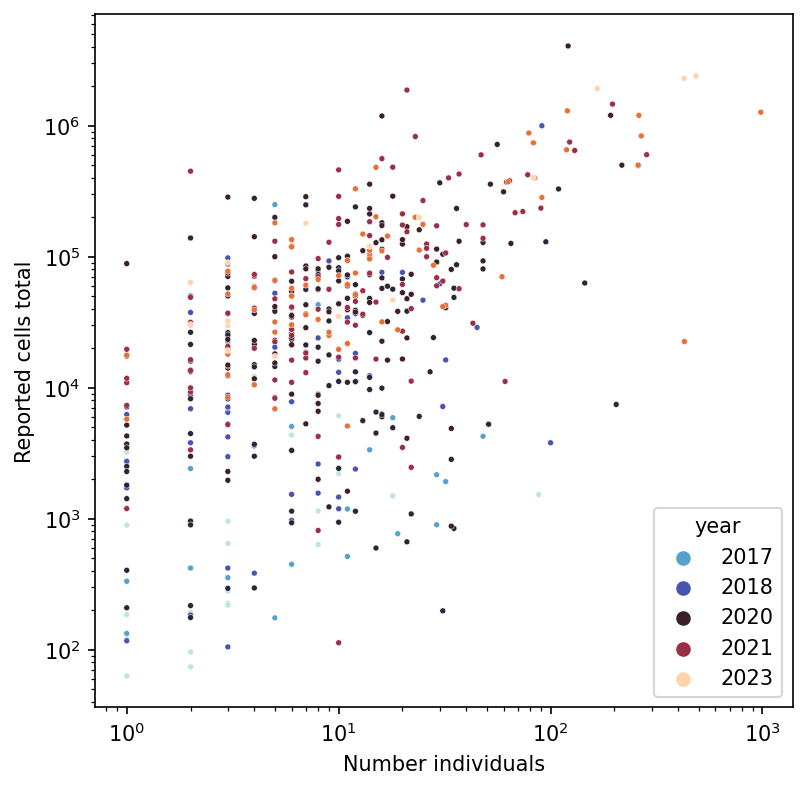

In [18]:
plt.figure(figsize=(6, 6), dpi=150)
sns.scatterplot(tissues_df, x="Number individuals", y="Reported cells total", hue="year", palette="icefire", s=8)
plt.xscale("log")
plt.yscale("log")

<AxesSubplot:xlabel='Number individuals', ylabel='Reported cells total'>

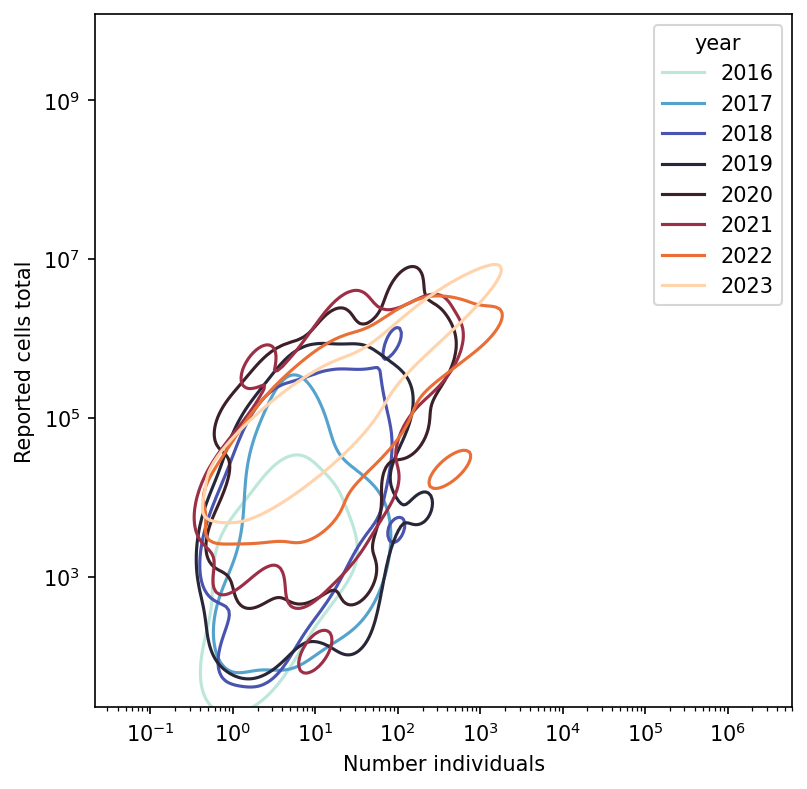

In [19]:
plt.figure(figsize=(6, 6), dpi=150)
sns.kdeplot(tissues_df, x="Number individuals", y="Reported cells total", hue="year", palette="icefire",
            log_scale=True, levels=1, cut=8)

In [20]:
np.isin(["Contrasts", "excluded", "DOI_oroginal", "do_DOI_match", "Shorthand_origina",
                 "do_shorthands_match", "Number individuals original"], tissues_df.columns)

array([ True, False, False, False, False, False, False])

In [22]:
tissues_df

,Shorthand,DOI,Authors,Journal,Title,Date,bioRxiv DOI,Reported cells total,Organism,Tissue,...,tSNE,H5AD location,Isolation,BC --> Cell ID _OR_ BC --> Cluster ID,Number individuals,date,year,month,day,cells_per_donor
17,Eltahla et al ICB,10.1038/icb.2016.16,"Auda A Eltahla, Simone Rizzetto, Mehdi R Piroz...",Immunol Cell Biol,Linking the T cell receptor to the single cell...,20160210,-,63.0,Human,Blood,...,NaN,NaN,NaN,NaN,1.0,2016-02-10,2016,2,10,63.000000
18,Krjutškov et al HReproduction,10.1093/humrep/dew008,"K. Krjutškov, S. Katayama, M. Saare, M. Vera-R...",Hum. Reprod.,Single-cell transcriptome analysis of endometr...,20160214,NaN,96.0,Human,"Culture, Endometrium",...,NaN,NaN,NaN,NaN,2.0,2016-02-14,2016,2,14,48.000000
19,Bjorklund et al NImmunology,10.1038/ni.3368,"Åsa K Björklund, Marianne Forkel, Simone Picel...",Nat Immunol,The heterogeneity of human CD127+ innate lymph...,20160215,-,648.0,Human,Tonsil,...,Yes,NaN,NaN,NaN,3.0,2016-02-15,2016,2,15,216.000000
20,Petropoulos et al Cell,10.1016/j.cell.2016.03.023,"Sophie Petropoulos, Daniel Edsgärd, Björn Rein...",Cell,Single-Cell RNA-Seq Reveals Lineage and X Chro...,20160409,-,1529.0,Human,Embryo,...,Yes,NaN,NaN,NaN,88.0,2016-04-09,2016,4,9,17.375000
21,Liu et al GBiology,10.1186/s13059-016-0932-1,"Siyuan John Liu, Tomasz J. Nowakowski, Alex A....",Genome Biol,Single-cell analysis of long non-coding RNAs i...,20160414,-,226.0,Human,Brain,...,NaN,NaN,NaN,NaN,3.0,2016-04-14,2016,4,14,75.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,Garrido-Trigo et al NCommunications,10.1038/s41467-023-40156-6,"Alba Garrido-Trigo, Ana M. Corraliza, Marisol ...",Nat Commun,Macrophage and neutrophil heterogeneity at sin...,20230726,NaN,46700.0,Human,Colon,...,NaN,NaN,NaN,NaN,18.0,2023-07-26,2023,7,26,2594.444444
759,Jia et al ACell,10.1111/acel.13969,"Minxue Jia, Paula A. Agudelo Garcia, Jose A. O...",Aging Cell,Transcriptional changes of the aging lung,20230914,NaN,NaN,Human,Lung,...,NaN,NaN,NaN,NaN,29.0,2023-09-14,2023,9,14,NaN
760,Mathys et al Cell,10.1016/j.cell.2023.08.039,"Hansruedi Mathys, Zhuyu Peng, Carles A. Boix, ...",Cell,Single-cell atlas reveals correlates of high c...,20230928,NaN,2300000.0,Human,Brain,...,NaN,NaN,NaN,NaN,427.0,2023-09-28,2023,9,28,5386.416862
761,Terekhova et al Immunity,10.1016/j.immuni.2023.10.013,"Marina Terekhova, Amanda Swain, Pavla Bohacova...",Immunity,Single-cell atlas of healthy human blood unvei...,20231113,NaN,1916367.0,Human,Blood,...,NaN,NaN,NaN,NaN,166.0,2023-11-13,2023,11,13,11544.379518


In [21]:
tissues_df.drop(
    ["Contrasts"],
    axis=1
).to_csv(
    "/Users/vladimir.shitov/Documents/science/PhD/2023_02_donors_plot/data/supplementary_1_papers_info.csv"
)

KeyError: "['excluded', 'DOI_oroginal', 'do_DOI_match', 'Shorthand_origina', 'do_shorthands_match', 'Number individuals original'] not found in axis"